This notebook contains code for accessing and analyzing the archives of [@gccaedits](https://twitter.com/gccaedits), a Twitter bot that tweets any time a Wikipedia article is edited anonymously from a IP address belonging to the federal government of Canada.

The raw data archive can be [accessed here](https://github.com/ruebot/gccaedits_data).

## Data prep

In [1]:
import requests
import pandas as pd
import glob, json
pd.set_option("max_colwidth", 140)

This block accesses the JSON Twitter data from GitHub and applies various regex operations to extract data points, like article title and government agency, from the tweet texts.

In [2]:
# Get JSON file from latest archive on repo and normalize it for pandas
json_file = 'https://github.com/ruebot/gccaedits_data/raw/main/20211209/tweet.js'
json_str = requests.get(json_file).text.replace('window.YTD.tweet.part0 = ', '')

df = pd.json_normalize(json.loads(json_str), max_level=0, record_path = ['tweet','entities', 'urls'], 
       meta =[['tweet', 'full_text'], ['tweet', 'created_at'], ['tweet', 'id']])

df.columns = [col.replace('tweet.', '') for col in df.columns]
    
df.created_at = pd.to_datetime(df.created_at)
df = df.sort_values('created_at')

# Extract type of article edited. If it's not specified in tweet text, make it "Article"
df['wiki_type'] = df.full_text.str.extract('^([A-Z][a-z]+):\w')
df.loc[df.wiki_type.isna(), 'wiki_type'] = 'Article'

# Extract article title and delete rows without it (they are other types of tweets)
df['article_title'] = df.full_text.str.extract('(.+) Wikipedia article')[0].str.replace('^[A-Z][a-z]+:(?! )', '', regex = True)
df = df[df.article_title.notna()]
df.article_title = df.article_title.replace('2017–18 Olympique de Marseille sea', '2017–18 Olympique de Marseille season')

# Extract government agency
df['gov_agency'] = (df.full_text.str.extract('anonymously (from|by) (.+)')[1]
                    .str.replace(' http.+', '', regex = True) )

In [3]:
df.shape

(18666, 10)

## Analysis

In [36]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib

# Function to bring up photo of diff. 
# This assumes the folder tweet_media has been downloaded from the repo and is in the working directory
# You can use this to download a single directory from a repo: https://download-directory.github.io/
def show_photo(tweet_id):
    media_path = 'gccaedits_data-master/gccaedits_data-master/20211209/tweet_media/'
    match = glob.glob(media_path + tweet_id + '*.png')
    if match:
        display(Image(filename = match[0]))

In [5]:
# Number of distinct articles edited

len(df.article_title.unique())

9402

In [6]:
# Earliest item in the data

df.created_at.min()

Timestamp('2014-07-09 14:22:45+0000', tz='UTC')

In [9]:
# Articles with most edits

df.article_title.value_counts().head(30)#.sort_values().plot.barh(figsize = (8,14), title = 'Number of edits to Wikipedia articles')

2017 European Curling Championships               128
Gastronomía de Canadá                              79
2017–18 Olympique de Marseille season              76
2017 World Women's Curling Championship            72
2019–20 Montreal Canadiens season                  68
HMCS Algonquin (DDG 283)                           64
90 Day Fiancé                                      62
List of programs broadcast by YTV                  62
2018 Ford World Women's Curling Championship       60
2018 World Mixed Doubles Curling Championship      58
2017 World Mixed Doubles Curling Championship      55
Judd Apatow                                        52
Vapour pressure of water                           46
2018 World Junior Curling Championships            43
List of small shopping centres in Montreal         41
Fairview Pointe-Claire                             37
2017 Ford World Men's Curling Championship         37
Galeries d'Anjou                                   36
Ottawa Macdonald–Cartier Int

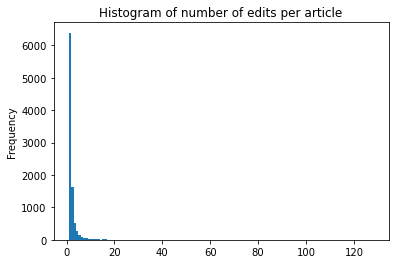

In [12]:
# Most articles were only edited once

df.article_title.value_counts().plot.hist(bins = df.article_title.value_counts().max(), 
                                          title = 'Histogram of number of edits per article')

C:\Users\Beto\miniconda3\envs\data\lib\site-packages\pandas\core\arrays\datetimes.py:1101: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


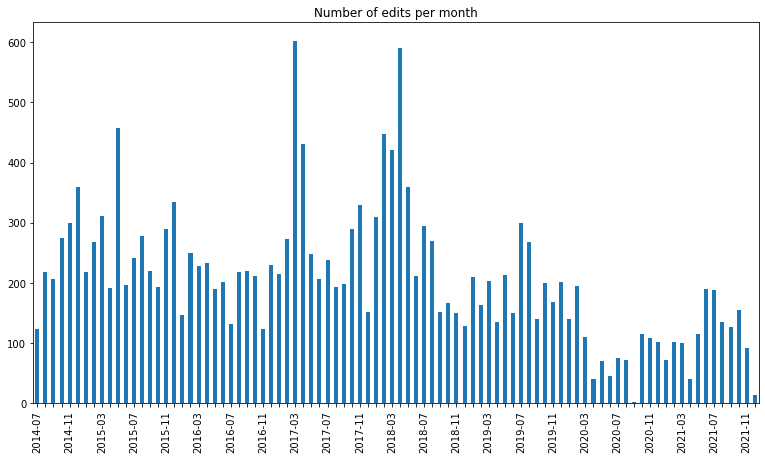

In [13]:
# Number of edits by year-month

bymonth = df.created_at.dt.to_period('M').value_counts().sort_index()

ax = bymonth.plot.bar(figsize =(13,7), title = 'Number of edits per month')
ax.grid(False, axis = 'x')
every_nth = 4
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

In [14]:
# Which articles were most edited at those two peaks

peaks = bymonth.nlargest(2).index
df[df.created_at.dt.to_period('M').isin(peaks)].article_title.value_counts().head(15)

2017 European Curling Championships                    88
2017 World Women's Curling Championship                70
2018 World Mixed Doubles Curling Championship          58
Madhumila                                              26
2016 Humpty's Champions Cup                            25
2017 Tim Hortons Brier                                 23
Gastronomía de Canadá                                  22
2010 European Curling Championships – Men's tournam    21
2009 European Curling Championships                    20
2017 WGC-Dell Technologies Match Play                  19
2009 Ford World Men's Curling Championship             18
2016 Boost National                                    18
Jane and Finch                                         16
2017 Elite 10                                          14
Mongolia's Next Top Model (cycle 1)                    13
Name: article_title, dtype: int64

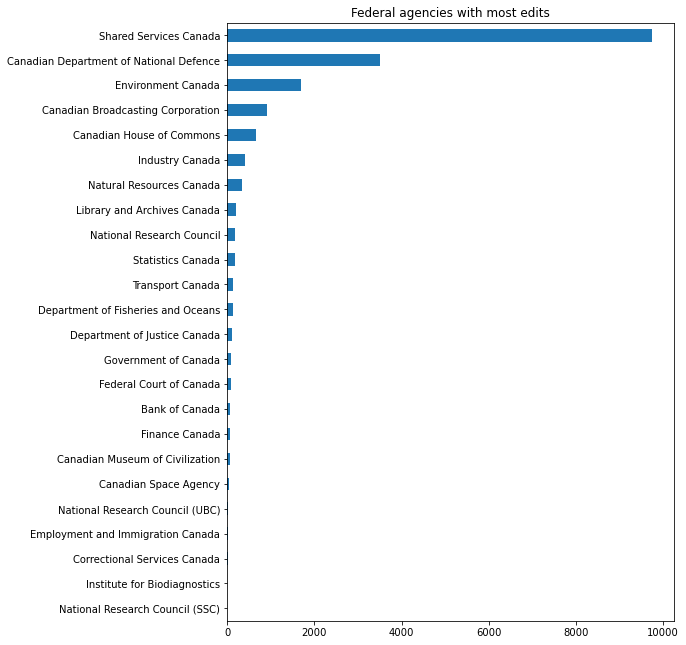

In [16]:
# Agencies that edited the most

df.gov_agency.value_counts().head(24).sort_values().plot.barh(figsize = (8,11), title = 'Federal agencies with most edits')

In [18]:
# Most frequent article-agency combos

(df.groupby(['gov_agency', 'article_title'])
 .size()
 .sort_values(ascending = False)
 .reset_index(name = 'edits')
 .groupby('gov_agency')
 .head(2)
 .query('edits > 1')
 .set_axis(['Agency', 'Article', 'Edits'], axis = 1)
 .query('Edits >= 10')
 .set_index('Agency')
)#.to_clipboard(index = False)

,Article,Edits
Agency,,
Shared Services Canada,2017 European Curling Championships,128
Shared Services Canada,Gastronomía de Canadá,79
Canadian Department of National Defence,2017–18 Olympique de Marseille season,76
Canadian Department of National Defence,HMCS Algonquin (DDG 283),64
Natural Resources Canada,Vapour pressure of water,46
Statistics Canada,Census in Canada,28
Canadian Broadcasting Corporation,Daytime (Canadian talk show),27
Canadian Broadcasting Corporation,"Milton, Ontario",26
Canadian House of Commons,Marjolaine Boutin-Sweet,24


In [19]:
# Unique number of articles edited per agency

df.groupby('gov_agency').article_title.nunique().sort_values(ascending = False)

gov_agency
Shared Services Canada                     4743
Canadian Department of National Defence    1777
Environment Canada                         1303
Canadian Broadcasting Corporation           409
Canadian House of Commons                   358
Industry Canada                             262
Natural Resources Canada                    195
Library and Archives Canada                 127
National Research Council                   112
Statistics Canada                           106
Transport Canada                             87
Department of Fisheries and Oceans           86
Department of Justice Canada                 79
Government of Canada                         55
Bank of Canada                               54
Finance Canada                               54
Canadian Museum of Civilization              49
Federal Court of Canada                      38
Canadian Space Agency                        19
Employment and Immigration Canada            10
National Research Council (UB

In [373]:
# Number of different agencies that edited individual articles

df.groupby('article_title').gov_agency.nunique().sort_values(ascending = False).head(20)

article_title
Gatineau                                          4
Julie Payette                                     4
Manitoba                                          3
Newfoundland and Labrador                         3
Bell CH-146 Griffon                               3
Chrystia Freeland                                 3
Serjeant-at-Arms                                  3
Winterlude                                        3
British Columbia                                  3
Le Régiment de Hull (RCAC)                        3
Québec (ville)                                    3
Kent Hehr                                         3
Toronto FC                                        3
Ottawa Macdonald–Cartier International Airport    3
Sandbox                                           3
The Brockville Rifles                             3
Gord Brown                                        3
Prince Edward Island                              3
Allan Rock                                        

In [444]:
# Articles most edited from HoC

df[df.gov_agency.str.contains('House of Commons')].article_title.value_counts().head(12)

Marjolaine Boutin-Sweet               24
Nancy Hartling                        15
Leona Alleslev                        11
Andrew Scheer                         11
Arnold Chan                            9
Nicola Di Iorio                        9
Genocide Prevention Group (Canada)     8
Michael Chan (Canadian politician)     8
Peter Kent                             8
Parliamentary Budget Officer           8
Dean Del Mastro                        7
Alex Nuttall                           7
Name: article_title, dtype: int64

Display the diffs for a given aticle title

In [20]:
search = 'Andrew Scheer'

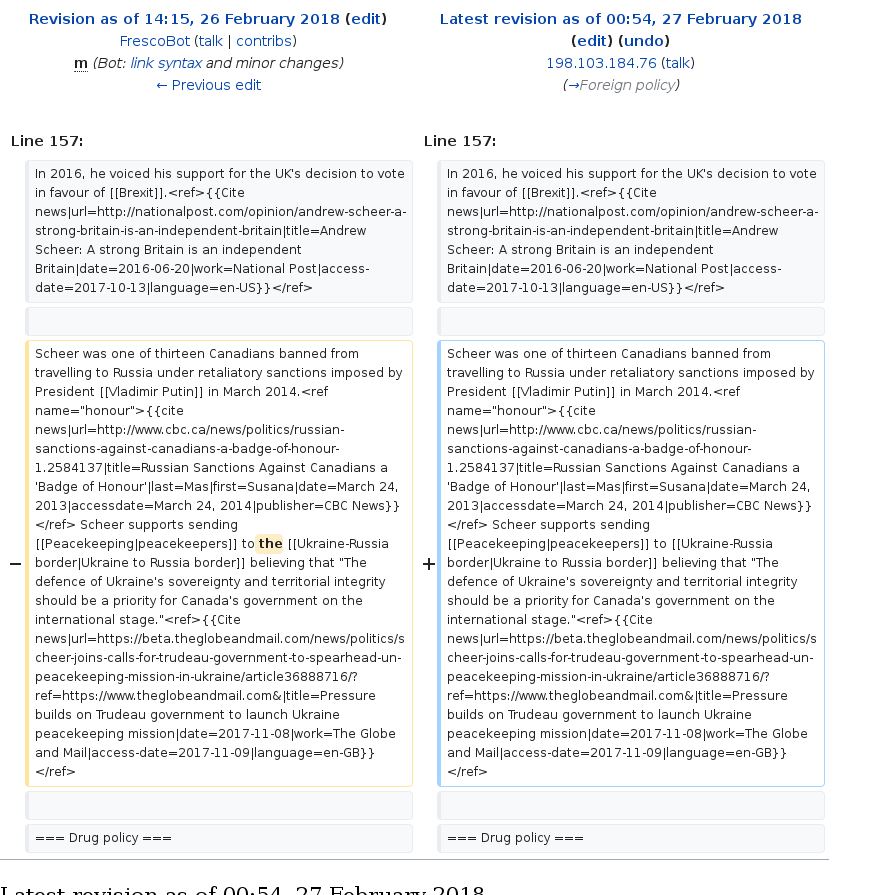

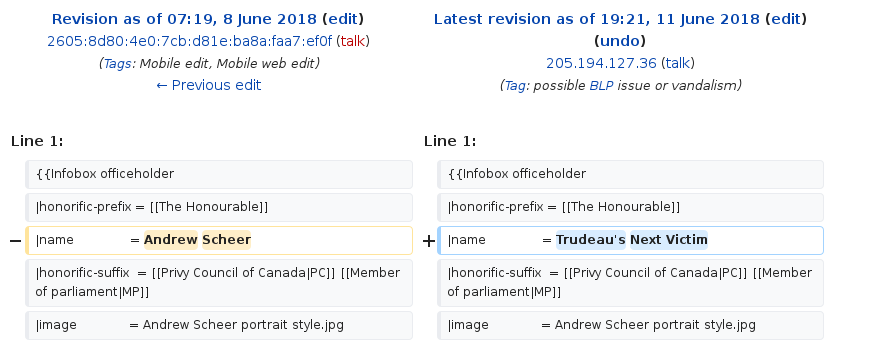

In [38]:
for twid in df[df.article_title == search].id:
    show_photo(twid)

In [507]:
# List the URLs for all the diffs, not just those with images

df[df.article_title == search].expanded_url

7045     https://en.wikipedia.org/w/index.php?diff=782862392&oldid=782851582
7044     https://en.wikipedia.org/w/index.php?diff=782863015&oldid=782862392
7043     https://en.wikipedia.org/w/index.php?diff=782863219&oldid=782863058
7042     https://en.wikipedia.org/w/index.php?diff=782864598&oldid=782863326
7091     https://en.wikipedia.org/w/index.php?diff=782864683&oldid=782864598
7090     https://en.wikipedia.org/w/index.php?diff=782864753&oldid=782864683
7089     https://en.wikipedia.org/w/index.php?diff=782865118&oldid=782864753
7088     https://en.wikipedia.org/w/index.php?diff=782865914&oldid=782865234
7087     https://en.wikipedia.org/w/index.php?diff=782866013&oldid=782865914
7086     https://en.wikipedia.org/w/index.php?diff=782866158&oldid=782866013
7085     https://en.wikipedia.org/w/index.php?diff=782866200&oldid=782866158
9674     https://en.wikipedia.org/w/index.php?diff=827836108&oldid=827747097
11320    https://en.wikipedia.org/w/index.php?diff=845432545&oldid=844941762

In [36]:
# Articles edited from CBC IPs

cbc = df[df.gov_agency == 'Canadian Broadcasting Corporation']
cbc.article_title.value_counts().head(20)

Daytime (Canadian talk show)                27
Milton, Ontario                             26
Q66548185                                   23
Campbellville Intermediate Baseball Team    21
Milton line                                 21
Steam Era                                   16
Q66725442                                   16
Canadian Broadcasting Corporation           16
Requests for deletions                      13
NHL on Sportsnet                            12
Ron Tugnutt                                 11
Clarkson Cup                                10
The Detectives (2018 TV series)              9
Ben Feldman                                  9
Dawn Coe-Jones                               8
John Tonelli                                 8
Le Téléjournal-Ontario                       8
Dickie Moore (ice hockey)                    7
Rock on the Range                            7
The Sketchersons                             7
Name: article_title, dtype: int64

In [38]:
cbc[cbc.article_title == 'Canadian Broadcasting Corporation'].expanded_url.values

array(['https://en.wikipedia.org/w/index.php?diff=708650363&oldid=706291967',
       'https://en.wikipedia.org/w/index.php?diff=708650446&oldid=708650363',
       'https://en.wikipedia.org/w/index.php?diff=708650537&oldid=708650446',
       'https://en.wikipedia.org/w/index.php?diff=708650748&oldid=708650537',
       'https://en.wikipedia.org/w/index.php?diff=708650911&oldid=708650748',
       'https://en.wikipedia.org/w/index.php?diff=708652093&oldid=708650911',
       'https://en.wikipedia.org/w/index.php?diff=708652262&oldid=708652093',
       'https://en.wikipedia.org/w/index.php?diff=708652710&oldid=708652262',
       'https://en.wikipedia.org/w/index.php?diff=708652743&oldid=708652710',
       'https://en.wikipedia.org/w/index.php?diff=708652956&oldid=708652743',
       'https://en.wikipedia.org/w/index.php?diff=708654484&oldid=708652956',
       'https://en.wikipedia.org/w/index.php?diff=708654537&oldid=708654484',
       'https://en.wikipedia.org/w/index.php?diff=708668612&oldi